## Preparing Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

import warnings
warnings.filterwarnings('ignore')

In [2]:
fits_path = '/home/rabbit/PSF_BuildUp/FITS_images/KIDS_9.5_-33.1.fits'
hdul = fits.open(fits_path, memmap=True)
image_data = hdul[0].data
wcs = WCS(hdul[0].header)

base_dir = '/home/rabbit/PSF_BuildUp/'
query_results_dir = os.path.join(base_dir, 'Query_results')
os.makedirs(query_results_dir, exist_ok=True)

gaia_dir = os.path.join(query_results_dir, 'gaia')
os.makedirs(gaia_dir, exist_ok=True)

In [3]:
cat_file = '/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/outparams_KIDS_9.5_-33.1.cat'

catalog = pd.read_csv(
    cat_file,
    sep='\s+',              
    comment='#',
    names=['NUMBER', 'MAG_AUTO', 'MAGERR_AUTO', 'X_IMAGE', 'Y_IMAGE', 
           'FLAGS', 'ELLIPTICITY', 'CLASS_STAR', 'FLUX_RADIUS'],
    usecols=['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'MAG_AUTO', 'FLUX_RADIUS', 'CLASS_STAR'],  
    index_col=False
)

x_pix = catalog['X_IMAGE'].values
y_pix = catalog['Y_IMAGE'].values

sky_coords = wcs.pixel_to_world(x_pix, y_pix)
catalog['RA_deg'] = sky_coords.ra.deg
catalog['Dec_deg'] = sky_coords.dec.deg

catalog_psf = catalog[catalog['CLASS_STAR'] > 0.99].copy()
output_file = '/home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf.cat'
catalog_psf.to_csv(output_file, index=False)

print(f"Saved catalog for PSF stars to {output_file}")
print(f"Number of PSF stars saved: {len(catalog_psf)}")

Saved catalog for PSF stars to /home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf.cat
Number of PSF stars saved: 346


In [4]:
cat_file_wcs = '/home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf.cat'


catalog = pd.read_csv(cat_file_wcs)
catalog = catalog[['NUMBER', 'RA_deg', 'Dec_deg']]

coords = SkyCoord(ra=catalog['RA_deg'].values*u.deg,
                  dec=catalog['Dec_deg'].values*u.deg)

print(f"Loaded catalog with {len(catalog)} stars")
print(catalog.sample(20).to_string(index=False))

Loaded catalog with 346 stars
 NUMBER    RA_deg    Dec_deg
  12485  9.971615 -33.672685
 100960 10.100938 -33.094221
 183583  9.460903 -32.719846
  77117  9.199077 -33.253738
 141144  9.123371 -32.773499
 126188  9.672378 -32.912460
  20049  8.901253 -33.651190
  68455  9.512072 -33.308936
  95689  9.195281 -33.133095
  51203  8.996782 -33.432222
 171112  9.197609 -32.634671
 146516  9.280102 -32.821550
 123783  9.645907 -32.949233
  11918  9.961280 -33.673571
 128967  9.087084 -32.892879
  78170  9.853843 -33.251000
  71861  9.658894 -33.298227
 158618  9.140597 -32.596762
  27087  9.954500 -33.603937
  47882  9.227010 -33.447807


## Astroquery using GAIA

In [5]:
fits_path = '/home/rabbit/PSF_BuildUp/FITS_images/KIDS_9.5_-33.1.fits'
output_file = '/home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_sources.csv'

hdul = fits.open(fits_path, memmap=True)
wcs = WCS(hdul[0].header)

ra_center = wcs.wcs.crval[0]
dec_center = wcs.wcs.crval[1]

nx = hdul[0].header['NAXIS1']
ny = hdul[0].header['NAXIS2']
cd1_1 = wcs.wcs.cd[0,0]
cd2_2 = wcs.wcs.cd[1,1]

radius = 0.5 * ((nx*cd1_1)**2 + (ny*cd2_2)**2)**0.5 * u.deg

print(f"Query center: RA={ra_center:.6f}, Dec={dec_center:.6f}, radius={radius:.3f}")

query = f"""
SELECT *
FROM gaiadr3.gaia_source
WHERE CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {ra_center}, {dec_center}, {radius.to(u.deg).value})
)=1
"""
Gaia.ROW_LIMIT = -1
job = Gaia.launch_job_async(query)
gaia_result = job.get_results()
print(f"Retrieved {len(gaia_result)} Gaia sources")

gaia_result.write(output_file, format='csv', overwrite=True)
print(f"Saved Gaia query result to {output_file}")

Query center: RA=9.504950, Dec=-33.137363, radius=0.761 deg
INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 5252 Gaia sources
Saved Gaia query result to /home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_sources.csv


In [6]:
psf_cat_file = '/home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf.cat'
gaia_file = '/home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_sources.csv'
output_file = '/home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_matched_psf.csv'

catalog_psf = pd.read_csv(psf_cat_file)
catalog_psf['RA_deg'] = catalog_psf['RA_deg'].astype(float)
catalog_psf['Dec_deg'] = catalog_psf['Dec_deg'].astype(float)

gaia_catalog = pd.read_csv(gaia_file)
gaia_catalog['ra'] = gaia_catalog['ra'].astype(float)
gaia_catalog['dec'] = gaia_catalog['dec'].astype(float)

coords_psf = SkyCoord(ra=catalog_psf['RA_deg'].values * u.deg,
                      dec=catalog_psf['Dec_deg'].values * u.deg)
coords_gaia = SkyCoord(ra=gaia_catalog['ra'].values * u.deg,
                       dec=gaia_catalog['dec'].values * u.deg)

idx, d2d, _ = coords_psf.match_to_catalog_sky(coords_gaia)
max_sep = 1.5 * u.arcsec
matches = d2d < max_sep

star_mask = gaia_catalog.loc[idx[matches], 'classprob_dsc_combmod_star'] >= 0.95
final_matches = matches.copy()
final_matches[matches] = star_mask.values

matched_catalog = catalog_psf[final_matches].copy()
matched_catalog['GAIA_RA'] = gaia_catalog.loc[idx[final_matches], 'ra'].values
matched_catalog['GAIA_Dec'] = gaia_catalog.loc[idx[final_matches], 'dec'].values
matched_catalog['GAIA_Rmag'] = gaia_catalog.loc[idx[final_matches], 'phot_rp_mean_mag'].values
matched_catalog['Separation_arcsec'] = d2d[final_matches].arcsec

matched_catalog.to_csv(output_file, index=False, float_format='%.3f')
print(f"Saved matched catalog to {output_file}")
print(f"Number of Gaia-confirmed stars: {len(matched_catalog)}")

Saved matched catalog to /home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_matched_psf.csv
Number of Gaia-confirmed stars: 254


Matched PSF stars: 254
Unmatched PSF stars: 92
Loaded image shape: (10017, 9356)


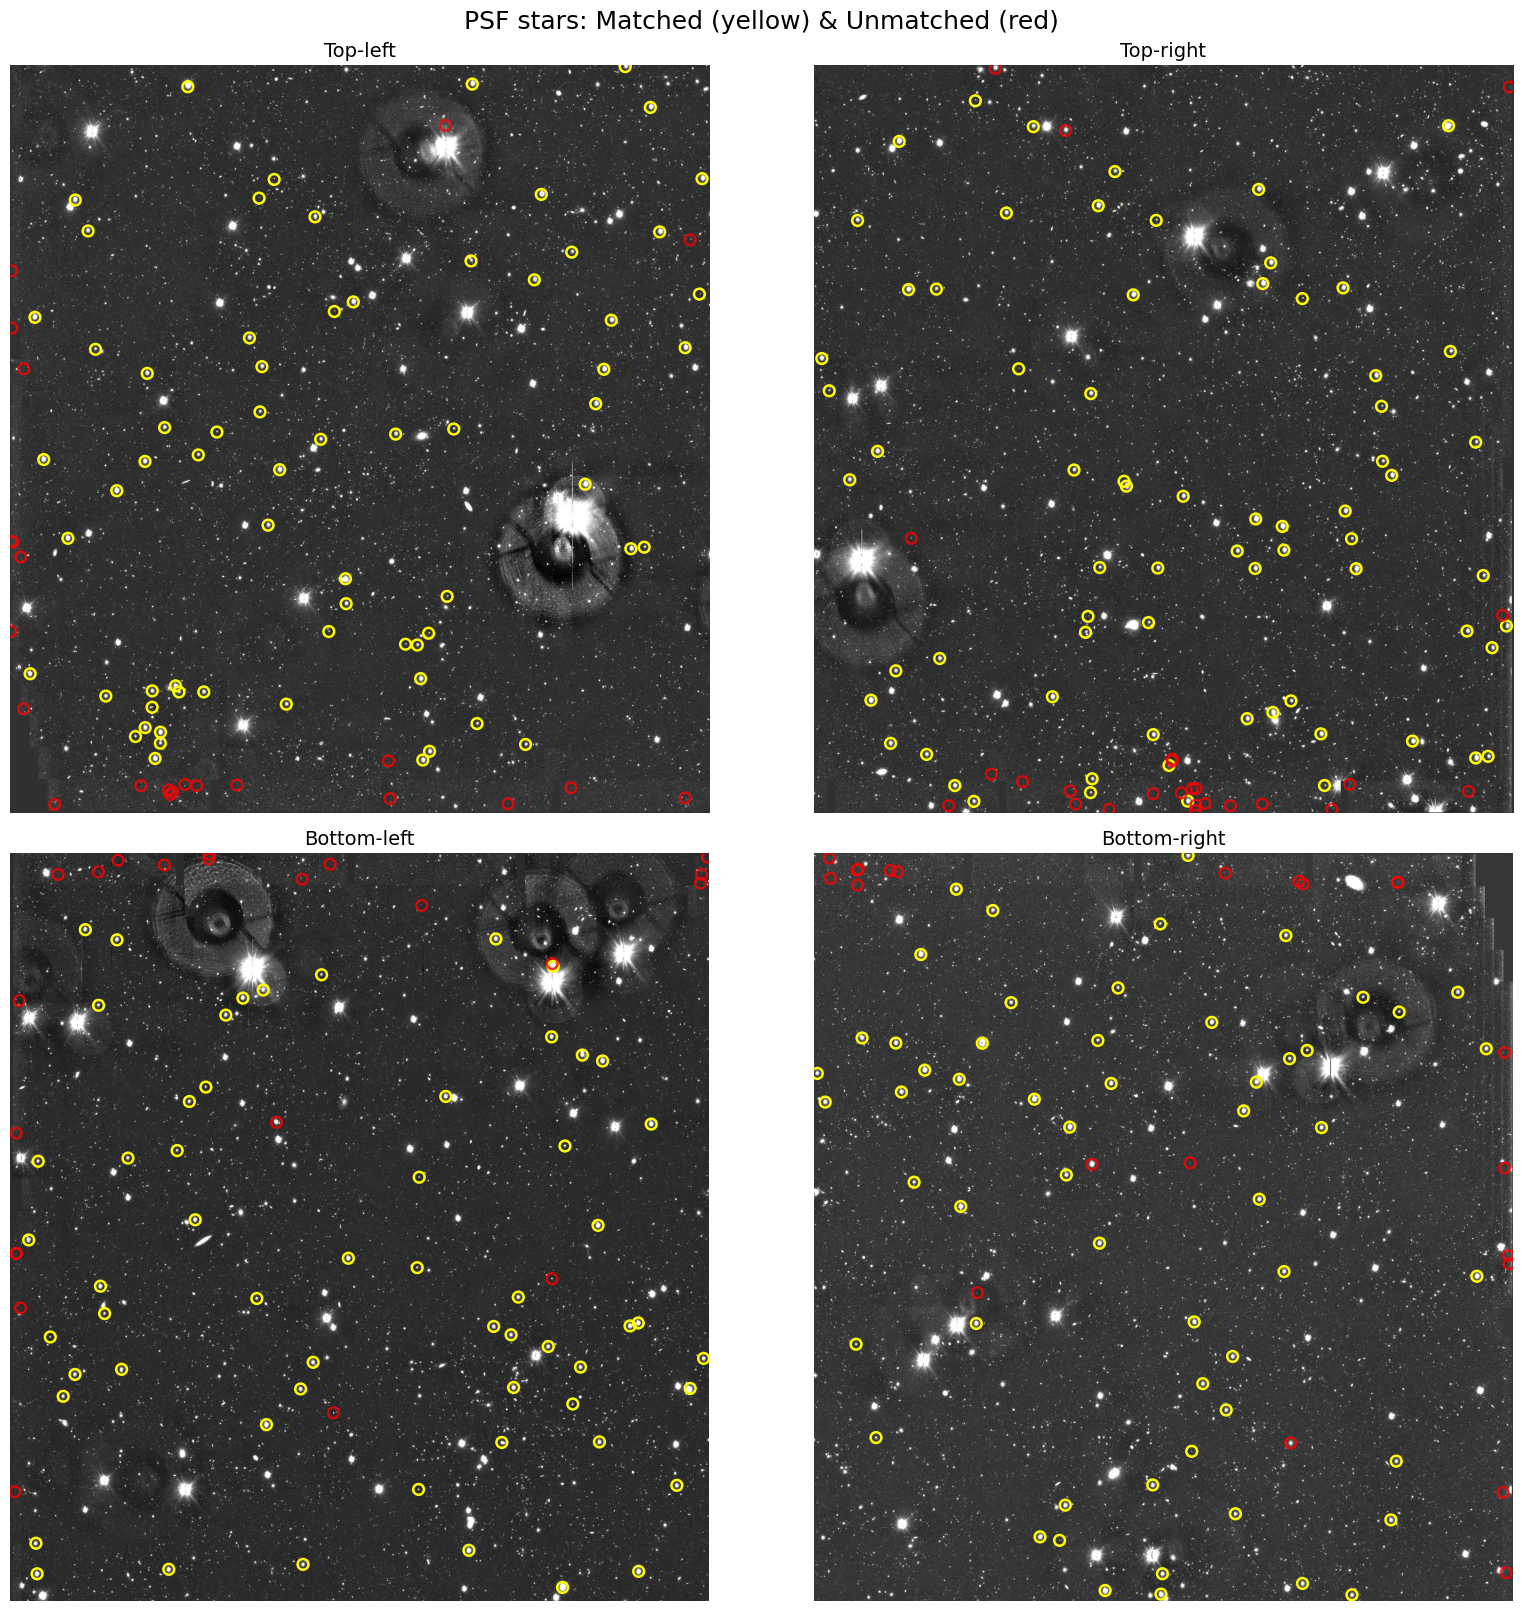

In [7]:
fits_path = '/home/rabbit/PSF_BuildUp/FITS_images/KIDS_9.5_-33.1.fits'
matched_file = '/home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_matched_psf.csv'
full_psf_file = '/home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf.cat'

psf_full = pd.read_csv(full_psf_file)
psf_matched = pd.read_csv(matched_file)
psf_unmatched = psf_full[~psf_full['NUMBER'].isin(psf_matched['NUMBER'])]

print(f"Matched PSF stars: {len(psf_matched)}")
print(f"Unmatched PSF stars: {len(psf_unmatched)}")

with fits.open(fits_path, memmap=True) as hdul:
    img_data = hdul[0].data.copy() 

img_data = img_data[::2, ::2]

for df in [psf_full, psf_matched, psf_unmatched]:
    df['X_IMAGE_ds'] = df['X_IMAGE'] / 2.0
    df['Y_IMAGE_ds'] = df['Y_IMAGE'] / 2.0

print(f"Loaded image shape: {img_data.shape}")

ny, nx = img_data.shape
cy, cx = ny // 2, nx // 2

quads = [
    img_data[:cy, :cx],      
    img_data[:cy, cx:],      
    img_data[cy:, :cx],      
    img_data[cy:, cx:]      
]

quad_titles = ['Top-left', 'Top-right', 'Bottom-left', 'Bottom-right']


def assign_to_quads(df):
    quad_list = []
    for qx, qy, qimg in [(0,0,quads[0]), (cx,0,quads[1]), (0,cy,quads[2]), (cx,cy,quads[3])]:
        mask = (
            (df['X_IMAGE_ds'] >= qx) & (df['X_IMAGE_ds'] < qx + qimg.shape[1]) &
            (df['Y_IMAGE_ds'] >= qy) & (df['Y_IMAGE_ds'] < qy + qimg.shape[0])
        )
        stars_in_quad = df[mask].copy()
        stars_in_quad['X_IMAGE_ds'] -= qx
        stars_in_quad['Y_IMAGE_ds'] -= qy
        quad_list.append(stars_in_quad)
    return quad_list

matched_quads = assign_to_quads(psf_matched)
unmatched_quads = assign_to_quads(psf_unmatched)

fig, axes = plt.subplots(2, 2, figsize=(16, 16), constrained_layout=True)

for ax, qimg, mq, uq, title in zip(axes.flat, quads, matched_quads, unmatched_quads, quad_titles):
    vmin, vmax = np.percentile(qimg, 5), np.percentile(qimg, 99)
    ax.imshow(qimg, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
    
    ax.scatter(
        mq['X_IMAGE_ds'].values,
        mq['Y_IMAGE_ds'].values,
        s=60,
        edgecolor='yellow',
        facecolors='none',
        linewidth=1.8,
        alpha=1.0,
        label='Matched PSF stars'
    )
    
    ax.scatter(
        uq['X_IMAGE_ds'].values,
        uq['Y_IMAGE_ds'].values,
        s=60,
        edgecolor='red',
        facecolors='none',
        linewidth=1.7,
        alpha=0.8,
        label='Unmatched PSF stars'
    )
    
    ax.set_title(title, fontsize=14)
    ax.axis('off')

plt.suptitle('PSF stars: Matched (yellow) & Unmatched (red)', fontsize=18)
plt.show()